In [2]:
from hough import imshow,bin_im2,plot_lines
from lines_generator import expand,norm
from skimage.transform import hough_line
from skimage.morphology import medial_axis
import numpy as np
import cv2
import keras
from keras.models import load_model

Using TensorFlow backend.


In [3]:
model = load_model('models/model3.h5')

In [4]:
def genPatches(im_path,delta_angle=3000,patche_size=17):
    
    #load image
    im_gray = cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)
    im_bin = bin_im2(im_gray)

    #hough transform
    im_h, theta, d = hough_line(im_bin,np.arange(-np.pi/2,np.pi/2,np.pi/delta_angle))
    im_h = im_h.astype('uint16')
    
    #Expand to convolution
    im_h = expand(np.array([im_h]),patche_size)[0]

    #first time return images
    yield im_gray,im_bin,im_h

    #sizes
    p = int((patche_size-1)/2)
    size = np.array(im_h.shape)-2*p
    
    #cut patches
    while(1):
        for y in range(size[0]):
            patches = list()
            for x in range(size[1]): 
                
                #cut
                patche = im_h[y:y+2*p+1,x:x+2*p+1]

                #matrix to vector
                patche = np.reshape(patche,patche_size**2)
                patches.append(patche)
                
            yield np.array(patches)


In [5]:
def reconstruct(label, size):
    im = np.reshape(label,size)
    return im

In [6]:
def mask2lines(mask,size_im):
    mask = mask.copy().astype(bool)
    
    #mask to list of pixels
    size = mask.shape
    grid = np.mgrid[0:size[0],0:size[1]].astype('uint16')
    xs = grid[1][mask]
    ys = grid[0][mask]

    #pixel to angle and distance
    dist_max = np.sqrt(size_im[0]**2+size_im[1]**2)
    angles = xs*np.pi/(size[1]-1) - np.pi/2
    dists = ys*(2*dist_max)/(size[0]-1) - dist_max
    
    return dists,angles

imgs/UFPR.jpg <br>
imgs/lines.png <br>
imgs/sudoku.jpg <br>
imgs/generator/im_[1~20].png

In [23]:
patche_size=17

name = 'imgs/generator/im_1.png'
gen = genPatches(name)
im_gray,im_bin,im_h = next(gen)

size_h = np.array(im_h.shape)
size_gray = np.array(im_gray.shape)

## Predict

In [24]:
%%time
pred = model.predict_generator(gen,steps = size_h[0]-patche_size+1,verbose=1)
pred = pred[:,0]

2938/2938 [==============================] - 81s 28ms/step
CPU times: user 3min 12s, sys: 16.9 s, total: 3min 29s
Wall time: 1min 21s


## Plot

1408


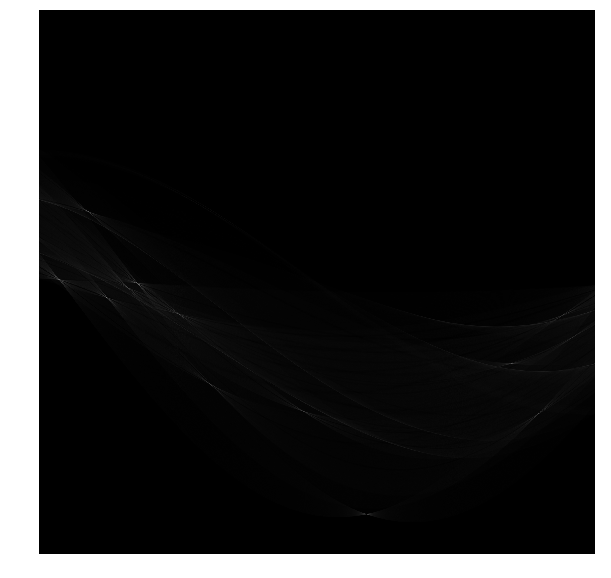

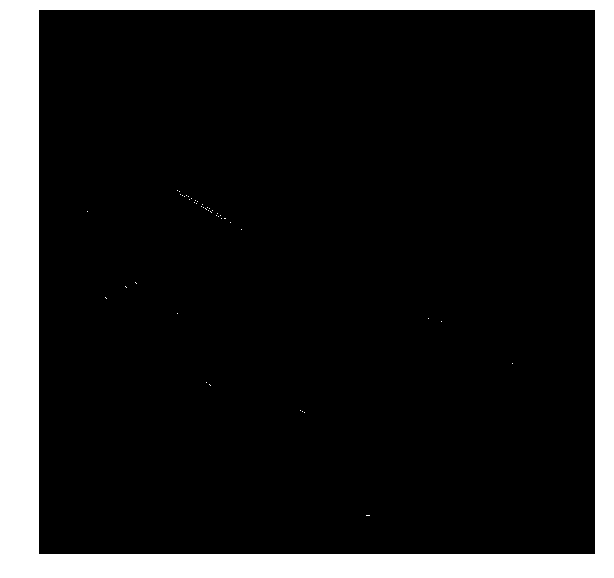

In [25]:
im = reconstruct(pred,size_h-patche_size+1)
mask = im>0.5
print(mask.sum())
imshow(im_h)
imshow(mask)

In [26]:
#cv2.imwrite('models/model3_mask.png',norm(mask))
#cv2.imwrite('models/model3_h.png',norm(im_h))

In [27]:
%%time
dists,angles = mask2lines(mask,size_gray)

CPU times: user 115 ms, sys: 77.8 ms, total: 193 ms
Wall time: 194 ms


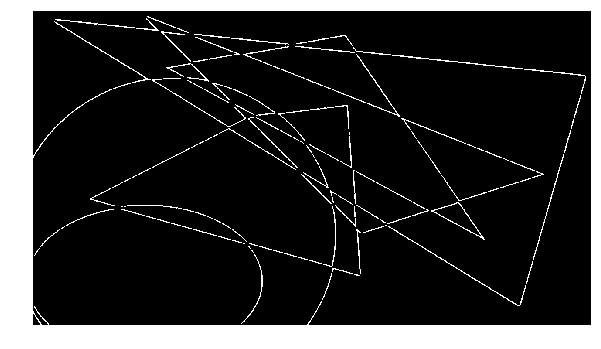

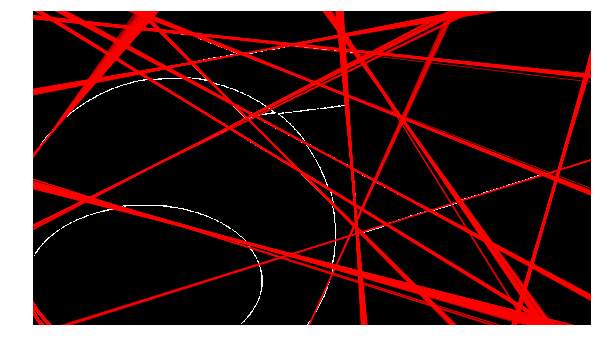

In [29]:
imshow(im_bin)
plot_lines(im_bin,dists,np.pi/2-angles) 

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
mask = cv2.erode(mask.astype('uint8'),kernel,iterations = 2)
print(mask.sum())
imshow(mask)

In [60]:
mask = (im>0.99).astype('uint8')
mask = cv2.dilate(mask,kernel,iterations = 1)
_, contours, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
print (len(contours))

102


In [61]:
centres = list()
for c in contours:
    try:
        moments = cv2.moments(c)
        center = [moments['m10']/moments['m00'],moments['m01']/moments['m00']]
        centres.append(center)
    except:
        None
centres = np.array(centres).astype('int')
print(len(centres))

84


In [62]:
centres.T.shape

(2, 84)

In [63]:
mask = np.zeros(mask.shape)
mask[centres[:,1],centres[:,0]] = 1

In [64]:
%%time
dists,angles = mask2lines(mask,size_gray)

CPU times: user 90.7 ms, sys: 72 ms, total: 163 ms
Wall time: 165 ms


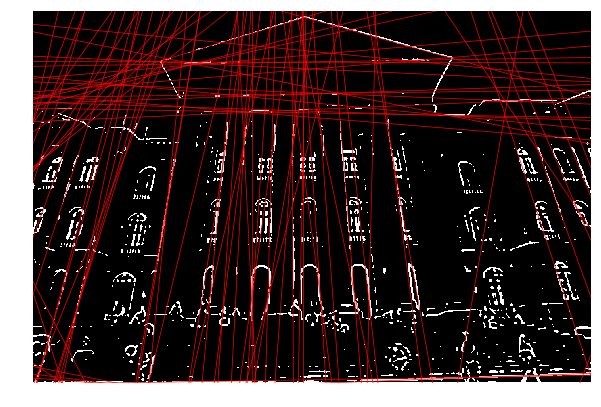

In [65]:
plot_lines(im_bin,dists,np.pi/2-angles) 

4904


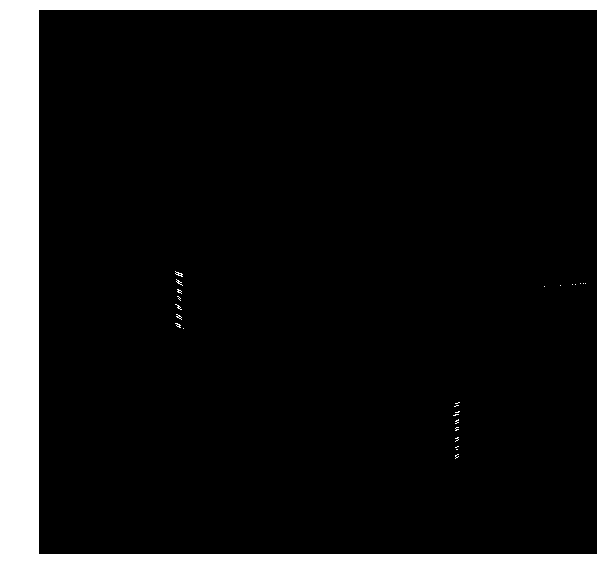

0


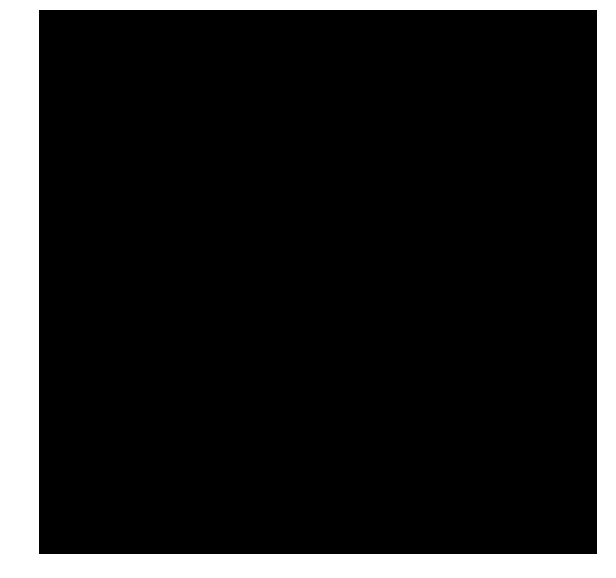

In [29]:
mask = im>0.99
#kernel = np.ones((3,3),np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
mask = cv2.dilate(mask.astype('uint8'),kernel,iterations = 1)
print(mask.sum())
imshow(mask)
mask = cv2.erode(mask,kernel,iterations = 4)
print(mask.sum())
imshow(mask)

In [30]:
%%time
dists,angles = mask2lines(mask,size_gray)

CPU times: user 134 ms, sys: 76 ms, total: 210 ms
Wall time: 209 ms


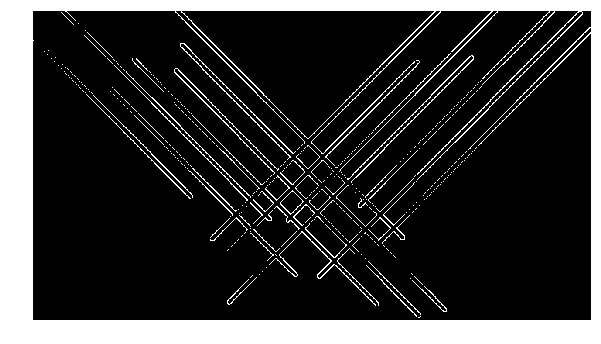

In [31]:
plot_lines(im_bin,dists,np.pi/2-angles) 